In [273]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [274]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Mounting Data From Drive

Here we are mounting data from the gogle drive. Please upload all the data files by creating a new folder called content in google drive

In [275]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Target Model

In [276]:
#here we are loading our Target model
target_model=tf.keras.models.load_model("/content/drive/My Drive/CryptoProject/trained_target_model.h5")

1st layer: Conv layer + Max Pooling

2nd layer: Conv layer + Max Pooling

3rd layer: Fully Conn (256 * 128)

4th layer: Fully COon (128 * 10)

In [277]:
target_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928 

How the Target Model work?

In [278]:
#here we are loading the partial test train data and their lables
traindata_partial=np.load("/content/drive/My Drive/CryptoProject/train_data_partial.npy")
trainlabels_partial=np.load("/content/drive/My Drive/CryptoProject/train_labels_partial.npy")
testdata_partial=np.load("/content/drive/My Drive/CryptoProject/test_data_partial.npy")
testlabels_partial=np.load("/content/drive/My Drive/CryptoProject/test_labels_partial.npy")

In [279]:
random=np.random.randint(0,10000, (10,))

In [280]:
rand_data=traindata_partial[random]

In [281]:
def show_data(image_data):
        num_row = 2
        num_col = 5
        fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
        for i in range(10):
            ax = axes[i//num_col, i%num_col]
            ax.set_axis_off()
            ax.imshow(image_data[i])

        plt.tight_layout()
        plt.show()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

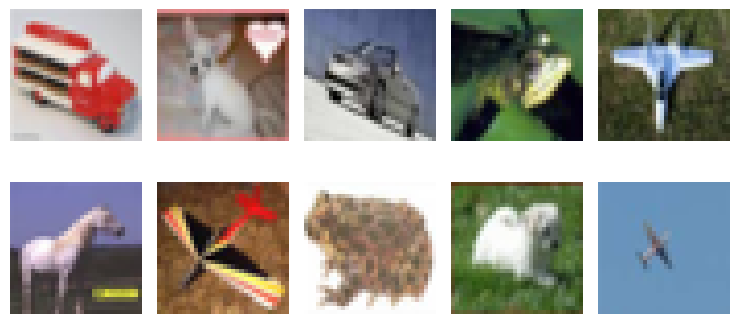

In [282]:
show_data(rand_data) #this is some of the random data which we are using to test out target model prediction

In [283]:
prediction=target_model(rand_data) #we are predicting the lables of the random data by feeding it to our target model

In [284]:
predict_label=tf.math.argmax(prediction, axis=1)
print(predict_label)

tf.Tensor([0 5 1 6 0 7 0 6 5 0], shape=(10,), dtype=int64)


In [285]:
#These are the lables of the random data predicted by out target model
for no in predict_label:
    print(class_names[no]) 

airplane
dog
automobile
frog
airplane
horse
airplane
frog
dog
airplane


In [286]:
first_10_labels=trainlabels_partial[random]
pred_accuracy=sum(first_10_labels==predict_label.numpy())/len(first_10_labels)
print('Accuracy of Target Model :', pred_accuracy)

Accuracy of Target Model : 0.9


Attack on target model

We create a shadow model

In [287]:
member_attributes=target_model(traindata_partial) #here we are feeding our target model to get member attributes 

In [288]:
member_attributes

<tf.Tensor: shape=(10000, 10), dtype=float32, numpy=
array([[ -8.09453   ,  -9.511581  ,   2.308946  , ...,   0.7989033 ,
        -11.765329  , -14.546907  ],
       [  1.4993261 ,  -1.5915823 ,   2.2405732 , ...,  -3.7230422 ,
         -5.4061685 ,   9.783438  ],
       [  1.2942592 ,   1.0332361 ,  -0.7563736 , ...,  -5.567007  ,
         -7.7828164 ,   8.665651  ],
       ...,
       [  0.69104695,   7.2425804 ,  -4.5836205 , ...,  -4.4953585 ,
          2.8515415 ,   7.202874  ],
       [ -1.0489266 ,  10.469152  ,  -2.3504214 , ...,  -3.8080924 ,
         -3.2119243 ,   3.6190464 ],
       [ -4.1086407 ,  -7.4670677 ,   3.2689018 , ...,   6.2206845 ,
        -11.102761  ,  -9.658786  ]], dtype=float32)>

In [289]:
non_member_attributes=target_model(testdata_partial) #here we are feeding our target model to get non-member attributes 

In [290]:
non_member_attributes

<tf.Tensor: shape=(5000, 10), dtype=float32, numpy=
array([[ -1.7871485 ,  -5.1116824 ,  -1.3135241 , ...,  -9.017349  ,
          3.2459524 ,  -4.4019    ],
       [  6.0741    ,   3.6214423 ,  -5.7152243 , ...,  -8.691189  ,
         11.031433  ,   1.1811364 ],
       [  0.8379353 ,   3.4393337 ,  -5.3589616 , ...,  -2.32182   ,
          3.0722766 ,   1.130228  ],
       ...,
       [ -3.689346  ,  -5.9777665 ,  -3.7441618 , ...,  -1.4427079 ,
         -5.288816  ,  -2.697714  ],
       [-14.829874  ,  -8.71036   ,   3.8072836 , ...,   0.63230956,
        -10.641227  , -12.714217  ],
       [  1.2543784 ,  15.432904  ,  -4.1131434 , ..., -12.167717  ,
         -8.198457  ,   5.549427  ]], dtype=float32)>

Data Preparations for Shadow Models

In [291]:
import pandas as pd
from sklearn.model_selection import train_test_split
#loading member data attributes to a list
k = (member_attributes.numpy()).tolist()
df = pd.DataFrame(k)
listof1 = [1 for i in range(10000)] #we are giving 1 as lable to member attributes
df[10] = listof1
#loading non-member data attributes to a list
y = (non_member_attributes.numpy()).tolist()
df1 = pd.DataFrame(y)
listof0 = [0 for i in range(5000)] #we are giving 0 as lable to non-member attributes
df1[10] = listof0
#we created a dataframe of memnber and non member data attributes
input = df.append(df1)
#we created data frame of member and non member lables
labels = input.iloc[:,[10]]
features = input.iloc[:,[0,1,2,3,4,5,6,7,8,9]]
#test and train split
train_INPUT, test_INPUT, train_INPUT_labels, test_INPUT_labels = train_test_split(features, labels, test_size=0.33, random_state=24)

<ipython-input-291-7b30c142f9f8>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  input = df.append(df1)


In [292]:
input.size

165000

In [293]:
import pandas as pd
from sklearn.model_selection import train_test_split


new_df_m = pd.DataFrame(k)
new_df = new_df_m.iloc[:5000]
listof1 = [1 for i in range(5000)]
new_df[10] = (listof1)

new_df_nm = pd.DataFrame(y)
listof0 = [0 for i in range(5000)]
new_df_nm[10] = listof0
new_input = new_df.append(new_df_nm)

labels_NEW = new_input.iloc[:,[10]]
features_NEW = new_input.iloc[:,[0,1,2,3,4,5,6,7,8,9]]
train_NEW_INPUT, test_NEW_INPUT, train_NEW_INPUT_labels, test_NEW_INPUT_labels = train_test_split(features_NEW, labels_NEW, test_size=0.30, random_state=24)

<ipython-input-293-e833f0e86890>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[10] = (listof1)
<ipython-input-293-e833f0e86890>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_input = new_df.append(new_df_nm)


Shadow Models

Shadow Model 1 - XGBOOST CLASSIFIER

In [294]:
import xgboost as xgb
from sklearn.metrics import classification_report
boost = xgb.XGBClassifier( learning_rate = 0.1,
                          n_estimators = 50000,
                          max_depth = 2,
                          subsample = 0.8,
                          colsample_bytree = 1,
                          gamma = 1)

In [295]:
#model_NEW_INPUT = boost.fit(train_NEW_INPUT, train_NEW_INPUT_labels.values.ravel())
#model_NEW_INPUT = boost.fit(train_NEW_INPUT, train_NEW_INPUT_labels)
XGboost_model_input = boost.fit(train_INPUT, train_INPUT_labels)

XGboost_predictive_labels = XGboost_model_input.predict(test_INPUT)
print('Shadow model 1 : XGboost Classification Report')
print(classification_report(test_INPUT_labels, XGboost_predictive_labels))

#model_NEW_INPUT.score(test_NEW_INPUT, test_NEW_INPUT_labels)

Shadow model 1 : XGboost Classification Report
              precision    recall  f1-score   support

           0       0.35      0.26      0.30      1643
           1       0.67      0.76      0.71      3307

    accuracy                           0.59      4950
   macro avg       0.51      0.51      0.50      4950
weighted avg       0.56      0.59      0.57      4950



In [296]:
XGboost_predictive_labels = XGboost_model_input.predict(train_INPUT)
print('With Ground truth Data')
print(classification_report(train_INPUT_labels, XGboost_predictive_labels))


With Ground truth Data
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3357
           1       1.00      1.00      1.00      6693

    accuracy                           1.00     10050
   macro avg       1.00      1.00      1.00     10050
weighted avg       1.00      1.00      1.00     10050



Shadow Model 2 - Random Forest Classifier 

In [297]:
from sklearn.ensemble import RandomForestClassifier
rlf = RandomForestClassifier(max_depth=2, random_state=12)

In [298]:
rlf_model = rlf.fit(train_INPUT, train_INPUT_labels)
rf_predictive_labels = rlf_model.predict(test_INPUT)
print('Shadow model 2 : Random Forest Classification Report')
print(classification_report(test_INPUT_labels, rf_predictive_labels))

<ipython-input-298-ab8f6979009a>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rlf_model = rlf.fit(train_INPUT, train_INPUT_labels)


Shadow model 2 : Random Forest Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1643
           1       0.67      1.00      0.80      3307

    accuracy                           0.67      4950
   macro avg       0.33      0.50      0.40      4950
weighted avg       0.45      0.67      0.54      4950



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [299]:
rf_predictive_labels = rlf_model.predict(train_INPUT)
print('With Ground truth Data')
print(classification_report(train_INPUT_labels, rf_predictive_labels))

With Ground truth Data
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      3357
           1       0.67      1.00      0.80      6693

    accuracy                           0.67     10050
   macro avg       0.83      0.50      0.40     10050
weighted avg       0.78      0.67      0.53     10050



Shadow Model 3 - Linear Regression


In [300]:
from sklearn.linear_model import LinearRegression
LR_model = LinearRegression().fit(train_INPUT, train_INPUT_labels)
LR_predictive_labels = LR_model.predict(test_INPUT)
LR_predictive_labels = np.round(LR_predictive_labels)
print('Shadow model 3 : Linear Regression Classification Report')
print(classification_report(test_INPUT_labels, LR_predictive_labels))

Shadow model 3 : Linear Regression Classification Report


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1643
           1       0.67      1.00      0.80      3307

    accuracy                           0.67      4950
   macro avg       0.33      0.50      0.40      4950
weighted avg       0.45      0.67      0.54      4950



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [301]:
LR_predictive_labels = LR_model.predict(train_INPUT)
LR_predictive_labels = np.round(LR_predictive_labels)
print('With Ground truth Data')
print(classification_report(train_INPUT_labels, LR_predictive_labels))

With Ground truth Data
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3357
           1       0.67      1.00      0.80      6693

    accuracy                           0.67     10050
   macro avg       0.33      0.50      0.40     10050
weighted avg       0.44      0.67      0.53     10050



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Shadow Model 4 - Perceptron 

In [302]:
from sklearn.linear_model import Perceptron
P_model = Perceptron(tol=1e-3, random_state=0)
P_model = P_model.fit(train_INPUT, train_INPUT_labels)
P_predictive_labels = P_model.predict(test_INPUT)
print('Shadow model 4 : Perceptron Classification Report')
print(classification_report(test_INPUT_labels, P_predictive_labels))

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Shadow model 4 : Perceptron Classification Report
              precision    recall  f1-score   support

           0       0.34      0.33      0.33      1643
           1       0.67      0.69      0.68      3307

    accuracy                           0.57      4950
   macro avg       0.51      0.51      0.51      4950
weighted avg       0.56      0.57      0.56      4950



In [303]:
P_predictive_labels = P_model.predict(train_INPUT)
print('With Ground truth Data')
print(classification_report(train_INPUT_labels, P_predictive_labels))

With Ground truth Data
              precision    recall  f1-score   support

           0       0.33      0.34      0.34      3357
           1       0.67      0.66      0.66      6693

    accuracy                           0.55     10050
   macro avg       0.50      0.50      0.50     10050
weighted avg       0.56      0.55      0.55     10050



Shadow Model 5 - AdaBoost

In [304]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
ABC_model = AdaBoostClassifier(n_estimators=100, random_state=0)
ABC_model = ABC_model.fit(train_INPUT, train_INPUT_labels)
ABC_predictive_labels = ABC_model.predict(test_INPUT)
print('Shadow model 5 : AdaBoost Classification Report')
print(classification_report(test_INPUT_labels, ABC_predictive_labels))

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Shadow model 5 : AdaBoost Classification Report
              precision    recall  f1-score   support

           0       0.40      0.02      0.03      1643
           1       0.67      0.99      0.80      3307

    accuracy                           0.67      4950
   macro avg       0.54      0.50      0.41      4950
weighted avg       0.58      0.67      0.54      4950



In [305]:
ABC_predictive_labels = ABC_model.predict(train_INPUT)
print('With Ground truth Data')
print(classification_report(train_INPUT_labels, ABC_predictive_labels))

With Ground truth Data
              precision    recall  f1-score   support

           0       0.74      0.03      0.05      3357
           1       0.67      1.00      0.80      6693

    accuracy                           0.67     10050
   macro avg       0.71      0.51      0.43     10050
weighted avg       0.70      0.67      0.55     10050



Shadow Model 6 - Support Vector Machine

In [306]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

SVM_model = make_pipeline(StandardScaler(), SVC(gamma='auto'))
SVM_model = SVM_model.fit(train_INPUT, train_INPUT_labels)
SVM_predictive_labels = SVM_model.predict(test_INPUT)
#SVM_predictive_labels = np.round(SVM_predictive_labels)

print('Shadow model 6 : Support Vector Machine Classification Report')
print(classification_report(test_INPUT_labels, SVM_predictive_labels))

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Shadow model 6 : Support Vector Machine Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1643
           1       0.67      1.00      0.80      3307

    accuracy                           0.67      4950
   macro avg       0.33      0.50      0.40      4950
weighted avg       0.45      0.67      0.54      4950



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [307]:
SVM_predictive_labels = SVM_model.predict(train_INPUT)
print('With Ground truth Data')
print(classification_report(train_INPUT_labels, SVM_predictive_labels))

With Ground truth Data
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      3357
           1       0.67      1.00      0.80      6693

    accuracy                           0.67     10050
   macro avg       0.83      0.50      0.40     10050
weighted avg       0.78      0.67      0.53     10050



Shadow Model 7 - Hist Gradient Boosting Classifier

In [308]:
from sklearn.ensemble import HistGradientBoostingClassifier
HGB_model = HistGradientBoostingClassifier().fit(train_INPUT, train_INPUT_labels)
HGB_predictive_labels = HGB_model.predict(test_INPUT)

print('Shadow model 7 : HIST Gradient Boosting Classification Report')
report = classification_report(test_INPUT_labels, HGB_predictive_labels)
print(report)


Shadow model 7 : HIST Gradient Boosting Classification Report
              precision    recall  f1-score   support

           0       0.25      0.00      0.00      1643
           1       0.67      1.00      0.80      3307

    accuracy                           0.67      4950
   macro avg       0.46      0.50      0.40      4950
weighted avg       0.53      0.67      0.54      4950



/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [309]:
HGB_predictive_labels = HGB_model.predict(train_INPUT)
print('With Ground truth Data')
print(classification_report(train_INPUT_labels, HGB_predictive_labels))

With Ground truth Data
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      3357
           1       0.67      1.00      0.80      6693

    accuracy                           0.67     10050
   macro avg       0.83      0.50      0.40     10050
weighted avg       0.78      0.67      0.53     10050



Mean f1 Score of our classifiers

In [312]:
import statistics

f1_scores = [0.71, 0.80, 0.80, 0.68, 0.80, 0.80, 0.80]


mean_f1 = statistics.mean(f1_scores)


print("Mean f1 Score of all shadow models:", mean_f1)


Mean f1 Score of all shadow models: 0.77


Mean Accuracy of our classifiers

In [313]:
import statistics

accuracy = [0.59, 0.67, 0.67, 0.57, 0.67, 0.67, 0.67]


mean_a = statistics.mean(accuracy)

print("Mean Accuracy of all shadow models:", mean_a)

Mean Accuracy of all shadow models: 0.6442857142857144
